In [ ]:
import pandas as pd

file_path = "/content/sample_data/clean_dataset.csv"
df = pd.read_csv(file_path)

summary = df.describe(include="all")
approved_counts = df['Approved'].value_counts()

total = len(df)
approved_percentages = (approved_counts / total) * 100
approved_counts, approved_percentages

(Approved
 1    343
 0    147
 Name: count, dtype: int64,
 Approved
 1    70.0
 0    30.0
 Name: count, dtype: float64)

approuved = 1 -> 70%
approuved = 0 -> 30%
Nombre de ligne = 490

Variables numériques = (Age, Debt, YearsEmployed, Income)
Variables catégoriques = (Industry, Ethnicity, Citizen)

# Step 1 : categorical columns transformed to numeric values


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['Industry', 'Citizen','Ethnicity']

encoder = {}

#transform non num data into num data
for c in categorical_columns:
  l = LabelEncoder()
  df[c] = l.fit_transform(df[c])
  encoder[c] = l

# standardize numerical data
num_columns = ['Debt', 'YearsEmployed', 'Income','Age','CreditScore']
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

# Step 2 : creation of training set and test set

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Approved','ZipCode'])   #without target column
y = df['Approved']  # target column only

#70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Step 3 : class histogram


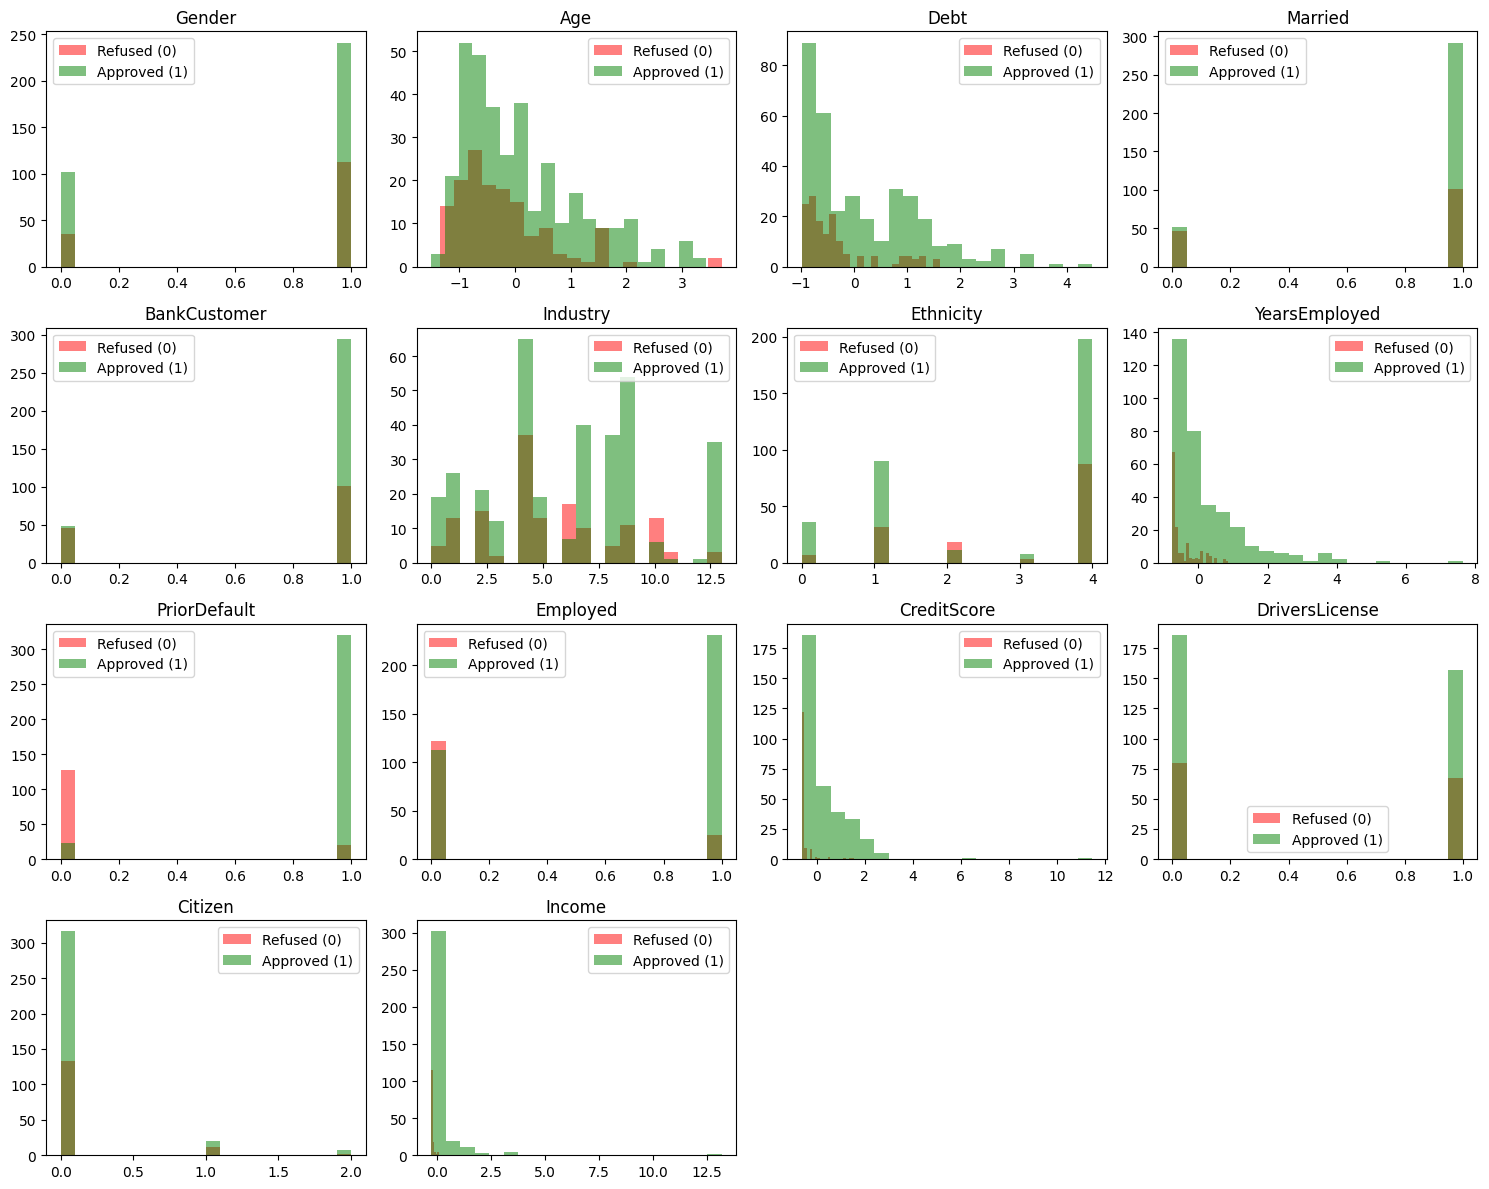

In [ ]:
import matplotlib.pyplot as plt

features = df.drop(columns=['Approved','ZipCode']).columns

plt.figure(figsize=(15, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    plt.hist(df[df['Approved'] == 0][feature], bins=20, alpha=0.5, label="Refused (0)", color='red')
    plt.hist(df[df['Approved'] == 1][feature], bins=20, alpha=0.5, label="Approved (1)", color='green')
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()

# Step 4 : Detecting Outliners

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

#  detect outliners with the 3 methods
#  Z-score (eart-type)
z_scores = np.abs(stats.zscore(X))

outliers_z = z_scores > 1

outliers_z = (outliers_z > 1).any(axis=1)

In [ ]:
#  IQR (Interquanrtile Range)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum(axis=1) > 0
outliers_iqr = outliers_iqr.to_numpy()

In [ ]:
#  Isolation Forest (Machine Learning)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_iso = iso_forest.fit_predict(X)
outliers_iso = outliers_iso == -1  # -1 = outlier, 1 = normal

In [ ]:
#  Merge result, a point is a outliner if he is detetc by 2 mehtods

outliers_combined = (outliers_iqr & outliers_iso) | (outliers_iqr & outliers_z )

print(f" numbers of outliners detected : {outliers_combined.sum()} / {len(X)}")

 numbers of outliners detected : 25 / 490


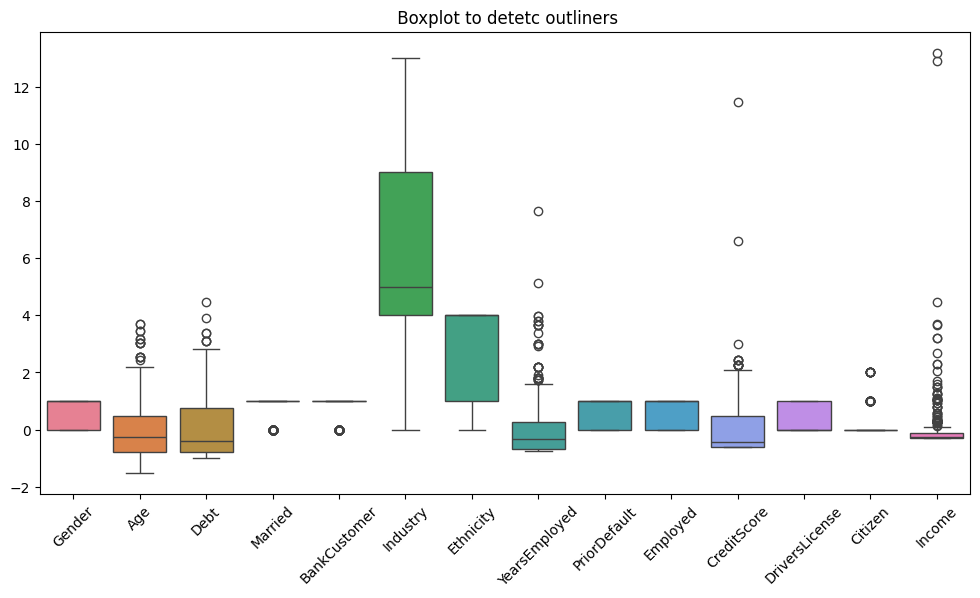

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title(" Boxplot to detetc outliners")
plt.show()

In [ ]:
# deleting outliners
X_cleaned = X[~outliers_combined]
y_cleaned = y[~outliers_combined]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, stratify=y_cleaned, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler

#  defining the grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10],  # Regularisation
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # kernel type
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # gama parameters (surtout utile pour rbf/poly/sigmoid)
    'degree': [2, 3, 4],  # only for poly kernel
    'decision_function_shape': ['ovr', 'ovo']  # Multiclasses One-Versus-Rest or One-Versus-One
}

#  SVM with `class_weight='balanced'`
svm = SVC(class_weight='balanced', probability=True)

#  finding the best hyperparameters with GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

#  best hyperparameters
best_params = grid_search.best_params_
print(" best hyperparameters found :", best_params)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
 best hyperparameters found : {'C': 10, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


Train models of SVM

In [ ]:
#  training svm with best parameters
best_svm = SVC(**best_params, class_weight='balanced', probability=True)
best_svm.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', degree=2, probability=True)

In [ ]:
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:, 1]  # probabilities for positive class

Accuracy: 0.9429
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        44
           1       0.95      0.97      0.96        96

    accuracy                           0.94       140
   macro avg       0.94      0.93      0.93       140
weighted avg       0.94      0.94      0.94       140



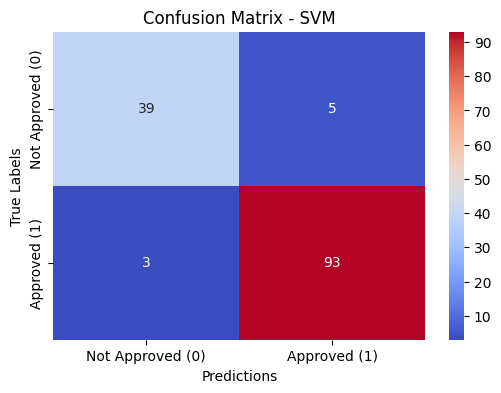

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# classification report (precision, reminder, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


conf_matrix_rbf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rbf, annot=True, fmt="d", cmap="coolwarm",xticklabels=["Not Approved (0)", "Approved (1)"],yticklabels=["Not Approved (0)", "Approved (1)"])
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM")
plt.show()